In [0]:
_ = !unzip '/content/drive/My Drive/images.zip' -d '/content'

In [36]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from sklearn.metrics import classification_report

batch_size = 64
epochs = 3
IMG_HEIGHT, IMG_WIDTH, channels = 220, 220, 3

dir = '/content/'
train_dir = os.path.join(dir, 'images')

train_gen = ImageDataGenerator(rescale=1.0/255.,
                               validation_split=0.2) # ustawienie podziału na 80 i 20 proc

train_generator = train_gen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    shuffle=True,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training')

validation_generator = train_gen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    shuffle=False,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='validation')

Found 12192 images belonging to 6 classes.
Found 3048 images belonging to 6 classes.


In [37]:
model = Sequential()

# add model layers
model.add(Conv2D(32, kernel_size=3, activation="relu", 
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), data_format="channels_last"))
model.add(Conv2D(32, kernel_size=5, activation="relu"))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
# model.add(Dropout(0.3)) # użycie gdy jest przeuczony, dużo więcej acc niż val_acc
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=3, activation="relu"))
model.add(Conv2D(8, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=3, activation="relu"))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
# warstwa łącząca conv2d z warstwą dense
model.add(Flatten())
# liczba taka ile wyjść, czyli 6 bo tyle jest typów
model.add(Dense(6, activation="softmax"))

# compile model using accuracy to measure model performance
model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              steps_per_epoch=train_generator.samples // batch_size,
                              use_multiprocessing=True, workers=6, epochs=epochs, shuffle=True)

Epoch 1/3
190/190 [==============================] - 113s 594ms/step - loss: 1.0641 - accuracy: 0.5914 - val_loss: 0.7769 - val_accuracy: 0.8297
Epoch 2/3
190/190 [==============================] - 105s 550ms/step - loss: 0.4924 - accuracy: 0.8484 - val_loss: 0.9186 - val_accuracy: 0.8753
Epoch 3/3
190/190 [==============================] - 105s 553ms/step - loss: 0.3663 - accuracy: 0.8920 - val_loss: 0.5921 - val_accuracy: 0.9055


In [76]:
validation_generator.reset()
probabilities = model.predict_generator(validation_generator, verbose=1)
# preds_cls_idx = probabilities.argmax(axis=1)

y_test = probabilities.argmax(axis=1)
y_pred = validation_generator.classes
print(classification_report(y_test, y_pred))

scores = model.evaluate_generator(validation_generator, verbose=1)
print(model.metrics_names[0] + " = ", scores[0])
print(model.metrics_names[1] + " = ", scores[1])

48/48 [==============================] - 9s 197ms/step
              precision    recall  f1-score   support

           0       0.62      0.96      0.75       330
           1       1.00      0.99      0.99       512
           2       0.98      0.90      0.94       556
           3       1.00      1.00      1.00       508
           4       1.00      0.72      0.83       706
           5       0.84      0.98      0.90       436

    accuracy                           0.91      3048
   macro avg       0.91      0.92      0.90      3048
weighted avg       0.93      0.91      0.91      3048

48/48 [==============================] - 10s 198ms/step
loss =  0.5920587778091431
accuracy =  0.9055117964744568


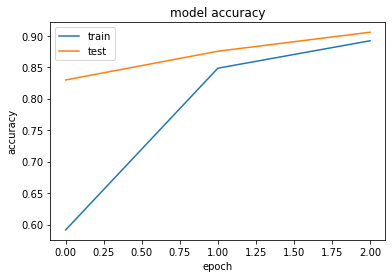

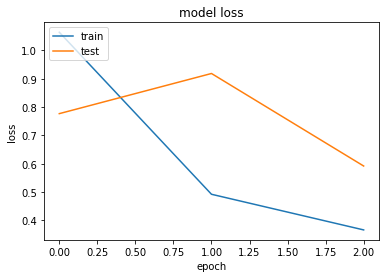

In [78]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Zapisanie modelu do pliku
model.save('model.h5')